<a href="https://colab.research.google.com/github/ShivamJaiswal19/Fractured-v-Non-fractured/blob/main/Medical_Dataset_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gc
import cv2
import glob
import random
import numpy as np
import pandas as pd
from os import path
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="X7Y4rvLT00jR9O2893oR")
project = rf.workspace("xrays-adn5j").project("x-rays-classification")
dataset = project.version(1).download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to X-Rays-(Classification)-1 in folder:: 100%|██████████| 3980/3980 [00:00<00:00, 6265.16it/s]


# ANALYZE THE DATASET

In [ ]:
dataset_directory = "/content/X-Rays-(Classification)-1/**/*"

def analyze_dataset(folder_path=dataset_directory):
    main_directory = glob.glob(folder_path)
    for sub_directories in main_directory:
        total_images = glob.glob(f"{sub_directories}/*.jpg")
        print(f"Total Images for {sub_directories.split('/')[-2]} Captured from {sub_directories.split('/')[-1]} is {len(total_images)}")

analyze_dataset()

Total Images for train Captured from Non_fractured is 2277
Total Images for train Captured from Fractured is 496
Total Images for test Captured from Non_fractured is 323
Total Images for test Captured from Fractured is 79
Total Images for valid Captured from Non_fractured is 668
Total Images for valid Captured from Fractured is 126


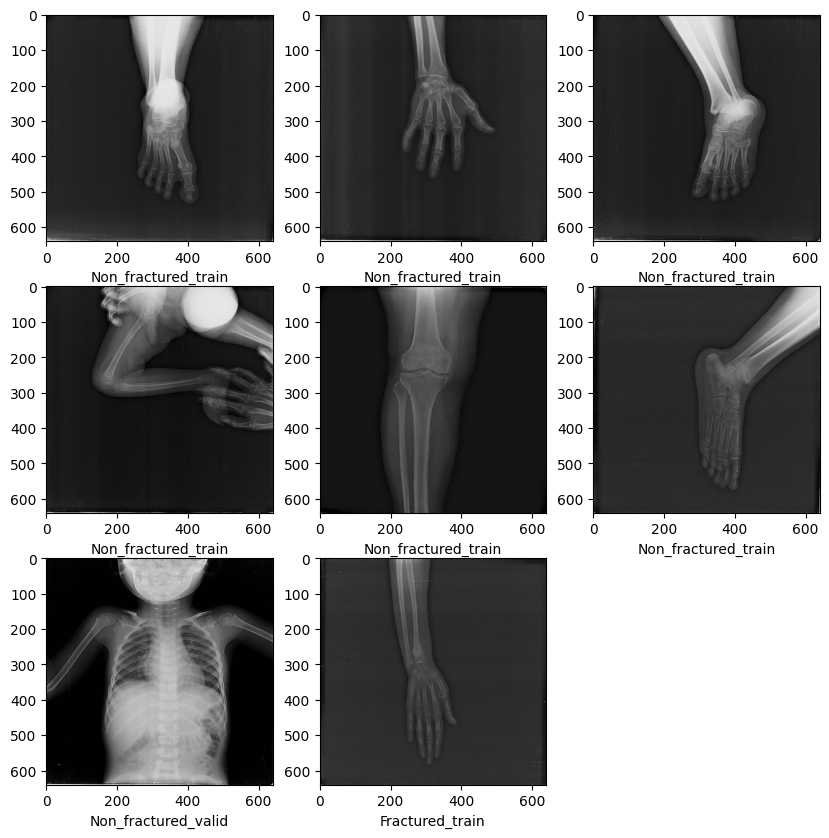

In [ ]:
all_dataset_images = glob.glob(f'{dataset_directory}/*.jpg')
# Generate Random Numbers
plt.figure(figsize=(10,10))

for i in range(1,9):
  plt.subplot(3,3,i)
  random_images = random.randint(0,len(all_dataset_images))
  plt.xlabel(all_dataset_images[random_images].split("/")[-2] + "_"+ all_dataset_images[random_images].split("/")[-3] )
  img = plt.imread(all_dataset_images[random_images])
  plt.imshow(img)

Image-Augumentation

In [ ]:
# HYPER-PARAMETERS
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT)
test_data = '/content/X-Rays-(Classification)-1/test'
training_data = '/content/X-Rays-(Classification)-1/train'
validation_data = '/content/X-Rays-(Classification)-1/valid'

In [ ]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1.0/255.0,
  )

training_datagen = image_data_generator.flow_from_directory(
    training_data,
    batch_size=20,
    target_size=IMG_SHAPE,
    shuffle=True,
)

validation_datagen = image_data_generator.flow_from_directory(
    validation_data,
    batch_size=20,
    target_size=IMG_SHAPE,
    shuffle = True
)

test_datagen = image_data_generator.flow_from_directory(
    test_data,
    batch_size=20,
    target_size=IMG_SHAPE,
    shuffle=True)

Found 2773 images belonging to 2 classes.
Found 794 images belonging to 2 classes.
Found 402 images belonging to 2 classes.


# TRAINING THE MODEL USING RESNET 50-v2

In [ ]:
base_model = ResNet50V2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
head_model = base_model
for layers in base_model.layers[:45]:
    layers.trainable=False
head_model = head_model.output
head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
head_model = tf.keras.layers.Dense(1600,activation='relu')(head_model)
head_model = tf.keras.layers.Dropout(0.2)(head_model)
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')(head_model)
model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                             

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [ ]:
history = model.fit(training_datagen,epochs=4,verbose=1,shuffle=True,validation_data=validation_datagen)

Epoch 1/4
139/139 [==============================] - 65s 241ms/step - loss: 1.1437 - accuracy: 0.7981 - val_loss: 0.4916 - val_accuracy: 0.8690
Epoch 2/4
139/139 [==============================] - 27s 197ms/step - loss: 0.3089 - accuracy: 0.8987 - val_loss: 0.4643 - val_accuracy: 0.8841
Epoch 3/4
139/139 [==============================] - 28s 197ms/step - loss: 0.1610 - accuracy: 0.9463 - val_loss: 0.4093 - val_accuracy: 0.8665
Epoch 4/4
139/139 [==============================] - 28s 199ms/step - loss: 0.1243 - accuracy: 0.9589 - val_loss: 0.5967 - val_accuracy: 0.8854


Text(0.5, 1.0, 'Training and validation loss')

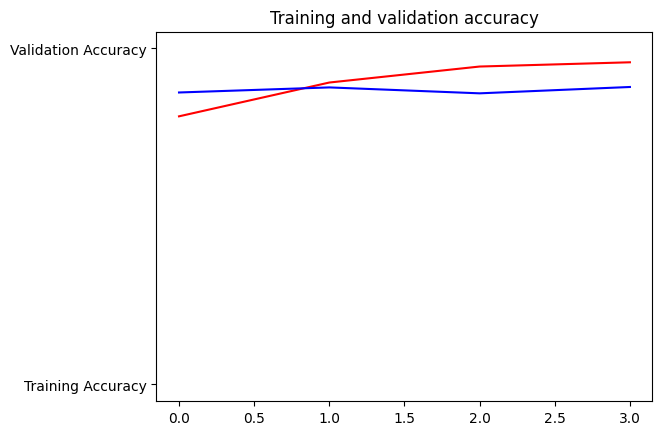

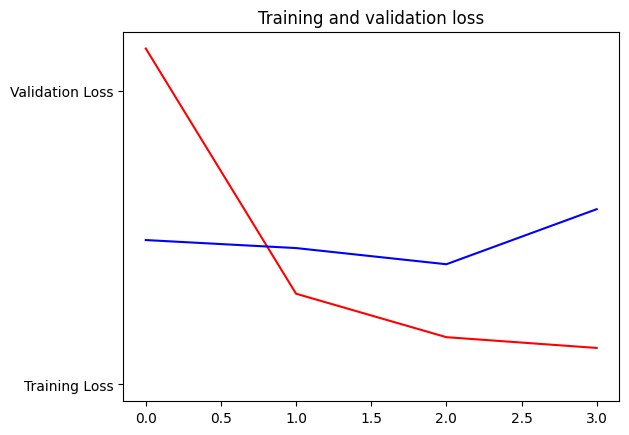

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
model.save('model_weights.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from os.path import join
model = load_model('/content/model_weights.h5')
shape = (256,256)
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [ ]:
img = decode_img("/content/X-Rays-(Classification)-1/test/Non_fractured/IMG0000000_jpg.rf.9edea0566ae4c8ba4c951242f4b1e1bf.jpg",shape)
pred = model.predict(img)
print(pred)
y_classes = np.argmax(pred)
print(y_classes)

1/1 [==============================] - 2s 2s/step
[[6.1601115e-04 9.9938393e-01]]
1


In [ ]:
img = decode_img("/content/X-Rays-(Classification)-1/test/Fractured/IMG0000456_jpg.rf.8d761720315f812fa2195506935de3e1.jpg",shape)
pred = model.predict(img)
print(pred)
y_classes = np.argmax(pred)
print(y_classes)

1/1 [==============================] - 0s 25ms/step
[[9.9969101e-01 3.0902174e-04]]
0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive
